<a href="https://colab.research.google.com/github/lrav35/diffusion/blob/main/QuickDiffusionModel_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 64
FIG_SIZE = (9, 9)
categories = [5, 6, 7]  # dos, frogs, horses
timesteps = 32
num_images = 25
time_bar = 1 - np.linspace(0, 1., timesteps + 1)

In [5]:
# load data and split into train and test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
idx = []
for i, cat in enumerate(y_train.squeeze()):
  if cat in categories:
    idx.append(i)
X_train = X_train[idx]
X_train = X_train / 127.5 - 1.0  # scale to -1 to 1

In [6]:
# functions for viewing images
def show_examples(data, num_images=num_images):
  # displays example images in a grid format
  plt.figure(figsize=FIG_SIZE)
  grid_size = int(np.sqrt(num_images))
  for i in range(num_images):
    plt.subplot(grid_size, grid_size, i + 1)
    img = scale(data[i])
    plt.imshow(img)
    plt.axis('off')

def scale(img):
    # min-max scaling
    img = img - img.min()
    img = img / img.max()
    return img

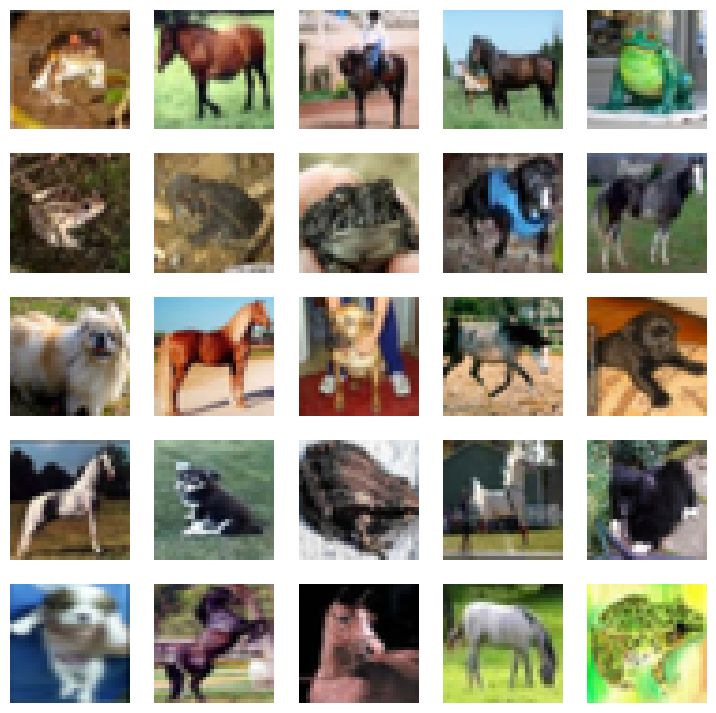

In [7]:
show_examples(X_train)

In [8]:
# util functions
def generate_ts(num):
  # generates random timesteps
  return np.random.randint(0, timesteps, size=num)

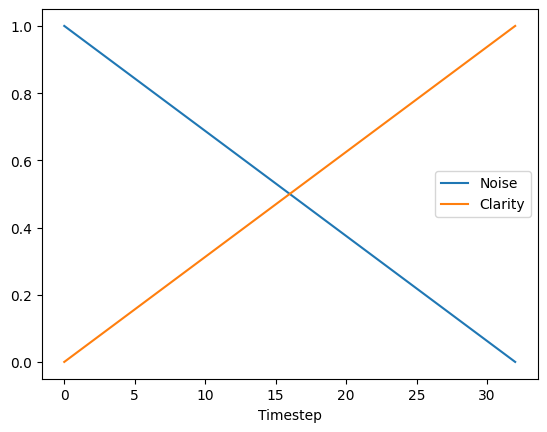

In [11]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.xlabel('Timestep')
plt.legend();

In [12]:
# forward noise
def forward_noise(img, ts):
  # slowly adds noise to images
  current_time = time_bar[ts]
  next_time = time_bar[ts + 1]

  noise = np.random.normal(size=img.shape)  # noise mask

  new_shape = tuple([-1] + [1 for _ in range(img.ndim - 1)])
  current_time = current_time.reshape(new_shape)
  next_time = next_time.reshape(new_shape)

  current_img = img * (1 - current_time) + noise * current_time
  next_img = img * (1 - next_time) + noise * next_time
  return current_img, next_img

In [13]:
ts = generate_ts(num_images)
current_imgs, next_imgs = forward_noise(X_train[:num_images], ts)

In [14]:
class UNetBlock(keras.layers.Layer):
  def __init__(self, filters=128, kernel_size=3, activation='relu'):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.activation = activation
    self.conv2d1 = keras.layers.Conv2D(self.filters, kernel_size=self.kernel_size, padding='same')
    self.conv2d2 = keras.layers.Conv2D(self.filters, kernel_size=self.kernel_size, padding='same')
    self.Activation1 = keras.layers.Activation(self.activation)
    self.Activation2 = keras.layers.Activation(self.activation)
    self.Activation3 = keras.layers.Activation(self.activation)
    self.dense = keras.layers.Dense(self.filters, activation=self.activation)
    self.reshape = keras.layers.Reshape((1, 1, self.filters))
    self.normalization = keras.layers.LayerNormalization()

  def call(self, x_img, x_ts):
    x_param = self.conv2d1(x_img)
    x_param = self.Activation1(x_param)

    time_param = self.dense(x_ts)
    time_param = self.Activation2(time_param)
    time_param = self.reshape(time_param)

    x_param = x_param * time_param

    x_out = self.conv2d2(x_img)
    x_out = x_out + x_param
    x_out = self.normalization(x_out)
    x_out = self.Activation3(x_out)

    return x_out

In [15]:
class MLPBlock(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.flatten = keras.layers.Flatten()
    self.concat = keras.layers.Concatenate()
    self.dense128 = keras.layers.Dense(128)
    self.normalization1 = keras.layers.LayerNormalization()
    self.normalization2 = keras.layers.LayerNormalization()
    self.activation1 = keras.layers.Activation('relu')
    self.activation2 = keras.layers.Activation('relu')
    self.dense512 = keras.layers.Dense(512)
    self.reshape = keras.layers.Reshape((4, 4, 32))

  def call(self, x, ts):
    x = self.flatten(x)
    x = self.concat([x, ts])
    x = self.dense128(x)
    x = self.normalization1(x)
    x = self.activation1(x)
    x = self.dense512(x)
    x = self.normalization2(x)
    x = self.activation2(x)
    x = self.reshape(x)
    return x

In [16]:
def make_model():
  x = x_input = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
  x_ts = x_ts_input = keras.layers.Input(shape=(1,), name='x_ts_input')

  x_ts = keras.layers.Dense(192)(x_ts)
  x_ts = keras.layers.LayerNormalization()(x_ts)
  x_ts = keras.layers.Activation('relu')(x_ts)

  x = x32 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x16 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x8 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x4 = UNetBlock()(x, x_ts)

  x = MLPBlock()(x, x_ts)

  x = keras.layers.Concatenate()([x, x4])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x8])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x16])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x32])
  x = UNetBlock()(x, x_ts)

  x = keras.layers.Conv2D(3, kernel_size=1, padding='same')(x)
  model = tf.keras.models.Model([x_input, x_ts_input], x)
  return model

In [17]:
model = make_model()

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 192)                  384       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 x_input (InputLayer)        [(None, 32, 32, 3)]          0         []                        

In [19]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

In [20]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(scale(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

In [21]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [22]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
model = tf.keras.models.load_model('SimpleUNet.keras')

# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 192)                  384       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192)                  0         ['layer_normalization[0][0

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

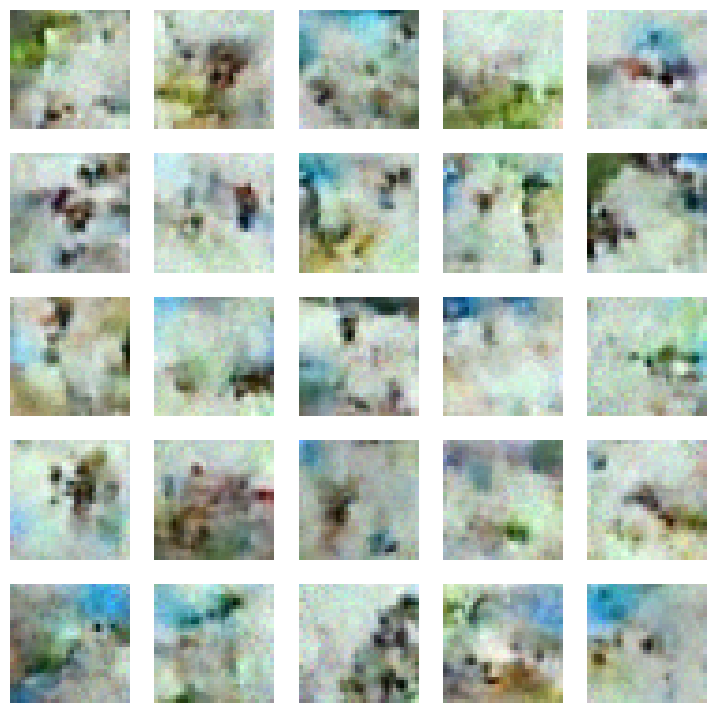

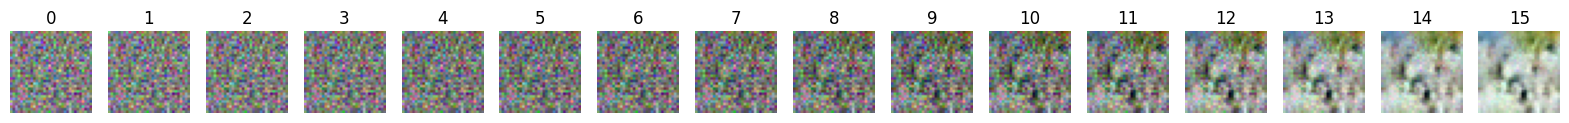

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

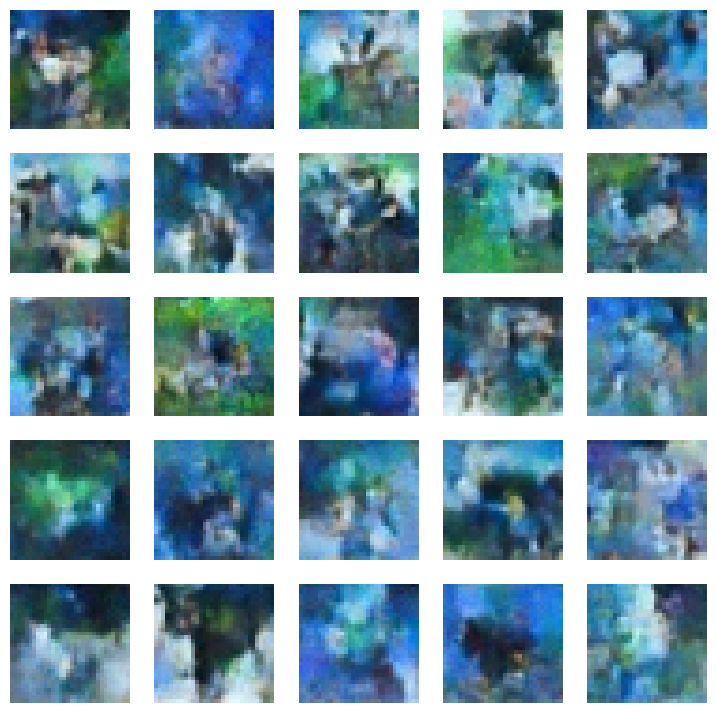

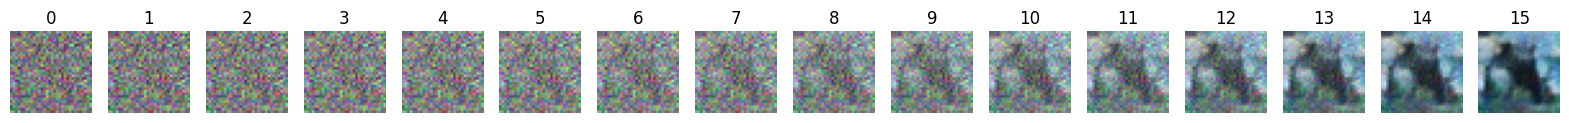

In [ ]:
for _ in range(5):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()